In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from torch.utils.data import DataLoader
# Add the path to utils.py
sys.path.append(r"c:\Document\Serieux\Travail\python_work\cEBNM_torch\py")

# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *

# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

batch_size=100
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist_data, batch_size=batch_size , shuffle=True)

# Function to generate y values
def generate_y(t, is_even):
     
    if is_even:        
        if t <.5 :
         return  np.random.normal(0, 2 )
        else :
            return np.zeros_like(t)
    else:
        if t>0.5:
            return np.random.normal(0, 2 )
        else :
            return  np.zeros_like(t)
        

# Custom Dataset class to handle MNIST images and simulated data
class SimulatedMNISTDataset(Dataset):
    def __init__(self, mnist_data, positions, y_values, y_noisy, digits, noise_level, label_type, image_label):
        self.image = mnist_data 
        self.mnist_data = mnist_data
        self.positions = torch.tensor(positions, dtype=torch.float32)
        self.y_values = torch.tensor(y_values, dtype=torch.float32)
        self.y_noisy = torch.tensor(y_noisy, dtype=torch.float32)
        self.digits = torch.tensor(digits, dtype=torch.long)
        self.noise_level = noise_level
        self.label_type = label_type
        self.image_label=image_label
        self.scale = autoselect_scales_mix_norm(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level)
        )
        
        self.Lim =torch.tensor(  get_data_loglik_normal(
            betahat=np.array(self.y_noisy),
            sebetahat=np.array(self.noise_level),
            location=0,
            scale=self.scale
                     ) , dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_data)

    
    def __getitem__(self, idx):
        image, _ = self.mnist_data[idx]
        position = self.positions[idx]
        y_value = self.y_values[idx]
        y_noisy = self.y_noisy[idx]
        digit = self.digits[idx]
        marginal_log_lik = self.Lim[idx]
        
        return image, digit, position, y_value, y_noisy, marginal_log_lik
    

        
        

# Generate the simulated dataset
n_samples = 10000
# Generate the simulated dataset
n_samples = 30000
noise_level = 1
positions = []
y_values = []
digits = []
y_noisy = []
label_type= []
image_label =[]
# Ensure unique indices are used
unique_indices = np.random.choice(len(mnist_data), size=n_samples, replace=False)
filtered_mnist_data = torch.utils.data.Subset(mnist_data, unique_indices)

# Run simulation to generate noisy data
for idx in unique_indices:
    image, label = mnist_data[idx]
    t = np.random.uniform(-0.5, 0.5)
    is_even = label % 2 == 0
    y = generate_y(t, is_even)
    noise = np.random.normal(0, noise_level)
    y_noisy_value = y + noise
    positions.append(t)
    y_values.append(y)
    y_noisy.append(y_noisy_value)
    digits.append(label)
    image_label.append(label)
    label_type.append(is_even)
    
positions = np.array(positions)
y_values = np.array(y_values)
y_noisy = np.array(y_noisy)
digits = np.array(digits)
label_type = np.array(label_type)
image_label = np.array(image_label)
noiseless=y_values
# Create custom dataset with the filtered MNIST dataset and simulated data
simulated_dataset = SimulatedMNISTDataset(
    mnist_data=filtered_mnist_data,
    positions=positions,
    y_values=y_values,
    y_noisy=y_noisy,
    digits=digits,
    noise_level=np.repeat(1, y_noisy.shape[0]),
    label_type=label_type,
    image_label =image_label
)


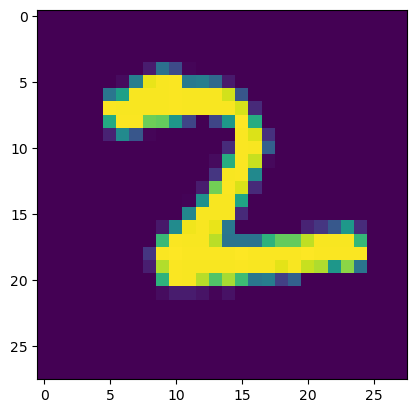

In [10]:
img, label =simulated_dataset.mnist_data[1]
img
plt.imshow(img.squeeze())

In [11]:
 
L_im = simulated_dataset.Lim
print(L_im [0])
scale= autoselect_scales_mix_norm(betahat=np.array(y_noisy),
                             sebetahat=np.repeat(1, y_noisy.shape[0]))
print(get_data_loglik_normal(y_noisy,  location=0,
                             sebetahat=np.repeat(1, y_noisy.shape[0]),
                             scale=scale)[0,])
      
 
n_epoch = 20
batch_size =128

tensor([-1.8117, -1.8098, -1.8044, -1.7851, -1.7360, -1.7200, -1.9573, -2.4743,
        -3.1168, -3.7967])
[-1.81170739 -1.80984514 -1.80442986 -1.78513494 -1.73603798 -1.71998596
 -1.95732894 -2.47431825 -3.11676061 -3.79673821]


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Helper function to calculate the size after the convolutional layers
def calculate_flattened_size(encoder, input_shape):
    """
    Calculate the flattened size after passing an input through the encoder CNN.
    Args:
        encoder: The convolutional encoder network.
        input_shape: Shape of the input (batch_size, channels, height, width).
    Returns:
        The flattened size after the convolutional layers.
    """
    with torch.no_grad():
        x = torch.rand(input_shape)  # Create a dummy input
        x = encoder(x)  # Pass it through the encoder
        return x.view(x.size(0), -1).shape[1]  # Return the flattened size

# CNN-VAE with output as a set of fitted pi values
class CNN_VAE_FittedPi(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, pi_dim):
        super(CNN_VAE_FittedPi, self).__init__()

        # Encoder: convolutional layers to encode the input image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 -> 4x4
            nn.ReLU(),
        )

        # Dynamically calculate the flattened size after the encoder
        flattened_size = calculate_flattened_size(self.encoder, (1, 1, 28, 28))

        # Fully connected layers for mean and log variance of latent space
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

        # Decoder: fully connected layers (with positional input) to output fitted pi values
        self.fc_decode = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, pi_dim)  # Output matches the number of pi components
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, pos):
        # Concatenate position to the latent vector
        z = torch.cat([z, pos], dim=1)
        x = self.fc_decode(z)
        # Apply softmax to ensure the output sums to 1 (fitted pi)
        return F.softmax(x, dim=1)

    def forward(self, x, pos):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        fitted_pi = self.decode(z, pos)
        return fitted_pi, mu, logvar

# Loss function for the penalized log-likelihood
def vae_loss_function(pred_pi, marginal_log_lik, mu, logvar, penalty=10, epsilon=1e-10):
    """
    Compute the penalized log likelihood function.
    
    Parameters:
    pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
    marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
    penalty (float): The penalty term for pi[:, 0].
    epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
    torch.Tensor: The total loss (negative penalized log likelihood + KL divergence).
    """
    # Reconstruction loss (penalized log-likelihood)
    L_batch = torch.exp(marginal_log_lik)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    inner_sum = torch.clamp(inner_sum, min=epsilon)
    recon_loss = torch.sum(torch.log(inner_sum))

    # Penalty term on the first component of pred_pi
    pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
    penalized_log_likelihood_value = recon_loss + (penalty - 1) * torch.log(pi_clamped)

    # KL divergence (Kullback-Leibler Divergence)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return the negative of the penalized log likelihood and the KL divergence
    return -penalized_log_likelihood_value + kl_loss

# Training function
def train_vae(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, digit, pos, y_value, y_noisy, marginal_log_lik) in enumerate(train_loader):
        data, pos, marginal_log_lik = data.to(device), pos.to(device).unsqueeze(1), marginal_log_lik.to(device)
        optimizer.zero_grad()
        pred_pi, mu, logvar = model(data, pos)
        loss = vae_loss_function(pred_pi, marginal_log_lik, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

# Hyperparameters
input_dim = 784  # MNIST images (28x28)
latent_dim = 20
hidden_dim = 400
pi_dim = simulated_dataset.Lim.size()[1]  # Number of components for fitted pi
n_epoch = 20
batch_size = 128

# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_VAE_FittedPi(input_dim, hidden_dim, latent_dim, pi_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(1, n_epoch + 1):
    train_vae(model, device, train_loader, optimizer, epoch)


Train Epoch: 1 [0/30000 (0%)]	Loss: 1.901632
Train Epoch: 1 [12800/30000 (43%)]	Loss: 1.624126
Train Epoch: 1 [25600/30000 (85%)]	Loss: 1.653560
====> Epoch: 1 Average loss: 1.6411
Train Epoch: 2 [0/30000 (0%)]	Loss: 1.670233
Train Epoch: 2 [12800/30000 (43%)]	Loss: 1.713978
Train Epoch: 2 [25600/30000 (85%)]	Loss: 1.690665
====> Epoch: 2 Average loss: 1.6324
Train Epoch: 3 [0/30000 (0%)]	Loss: 1.657821
Train Epoch: 3 [12800/30000 (43%)]	Loss: 1.638749
Train Epoch: 3 [25600/30000 (85%)]	Loss: 1.569464
====> Epoch: 3 Average loss: 1.6319
Train Epoch: 4 [0/30000 (0%)]	Loss: 1.559610
Train Epoch: 4 [12800/30000 (43%)]	Loss: 1.409208
Train Epoch: 4 [25600/30000 (85%)]	Loss: 1.468545
====> Epoch: 4 Average loss: 1.6315
Train Epoch: 5 [0/30000 (0%)]	Loss: 1.674083
Train Epoch: 5 [12800/30000 (43%)]	Loss: 1.759804
Train Epoch: 5 [25600/30000 (85%)]	Loss: 1.601481
====> Epoch: 5 Average loss: 1.6315
Train Epoch: 6 [0/30000 (0%)]	Loss: 1.658330
Train Epoch: 6 [12800/30000 (43%)]	Loss: 1.784972


In [13]:


input_dim = 784  # MNIST images (28x28)
hidden_dim = 400
# Main training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim, hidden_dim, simulated_dataset.Lim.size()[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(simulated_dataset, batch_size=batch_size , shuffle=True)

for epoch in range(1, n_epoch + 1):
    train(model, device, train_loader, optimizer, epoch)


NameError: name 'MLP' is not defined